# **Working memory training**: Degree distribution check

**Last edited:** 12-01-2019

### Section 1.0. Load data and print useful information
- making imports
- loading all data
- determining subjects included in the analysis (as indices list for 5-D data arrays)
- vectorizing connection matrices

In [70]:
from IPython.core.pylabtools import figsize
from jupyterthemes import jtplot
jtplot.style('grade3', ticks=True, context='notebook')

from datetime import timedelta
from time import time

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import itertools
import random
import bct
%matplotlib inline

from load_data import *

In [71]:
# Subjects with complete neuroimaging data
sub_mat = grp_ass[~grp_ass['group'].isnull()]
sub_mat = sub_mat.reset_index() # Index now matching numpy arrays
del sub_mat['index']

# Subjects included in dual n-back analysis
sub_dual = sub_mat[~sub_mat['sub'].isin(ex_dual_mot)] # Exclude dual
print('=== Subjects in dual n-back: {}'.format(len(sub_dual)))
print(sub_dual.index.values)
# sub_dual.index[sub_dual['group'] == 'Control'].values
# sub_dual.index[sub_dual['group'] == 'Experimental'].values

# Subjects included in rest analysis
sub_rest = sub_mat[~sub_mat['sub'].isin(ex_rest)] 
print('\n=== Subjects in resting state: {}'.format(len(sub_rest)))
print(sub_rest.index.values)

# Subjects included in both rest and task
sub_both = sub_mat[~sub_mat['sub'].isin(ex_rest + ex_dual_mot)]
print('\n=== Subjects in both rest and task: {}'.format(len(sub_both)))
print(sub_both.index.values)

=== Subjects in dual n-back: 42
[ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 40 41 42 43 44 45]

=== Subjects in resting state: 41
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 35 38 39 40 41 42 43 44 45]

=== Subjects in both rest and task: 38
[ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 35 38 40 41 42 43 44 45]


In [72]:
# Vectorize 5-D matrices into 4-D matrices returning upper diagonal elements 
# of connection matrix 
get_max_edge = lambda x: int(x * (x-1) / 2) 

n_pow = mat_pow.shape[-1]
n_sch = mat_sch.shape[-1]
m_pow = get_max_edge(n_pow)
m_sch = get_max_edge(n_sch)
triu_ind_pow = np.triu_indices(n_pow, k=1)
triu_ind_sch = np.triu_indices(n_sch, k=1)

shape = list(mat_pow.shape[:3])
mat_pow_v = np.empty(tuple(shape + [m_pow]))
mat_sch_v = np.empty(tuple(shape + [m_sch]))

for sub in range(shape[0]):
    for ses in range(shape[1]):
        for task in range(shape[2]):
            mat_pow_v[sub, ses, task] = mat_pow[sub, ses, task][triu_ind_pow]
            mat_sch_v[sub, ses, task] = mat_sch[sub, ses, task][triu_ind_sch]

print('mat_pow_v shape: {}'.format(mat_pow_v.shape))
print('mat_sch_v shape: {}'.format(mat_sch_v.shape))

mat_pow_v shape: (46, 4, 3, 34716)
mat_sch_v shape: (46, 4, 3, 44850)


### Section 1.1. Overall degree distribution
Display weighted **degree distribution** using kernel density estimation depending on:
* task condition
* session
* experimental group

In [15]:
def draw_kde_hist(data, color, label):
    sns.distplot(
        data,
        hist=False,
        kde=True,
        color=color,
        kde_kws={'linewidth': 2},
        label=label)
    
color = {
    'rest': sns.color_palette("hls", 8)[2],
    '1-back': sns.color_palette("hls", 8)[1],
    '2-back': sns.color_palette("hls", 8)[0]}

#### Schaefer atlas mean degree distributions (all sessions)

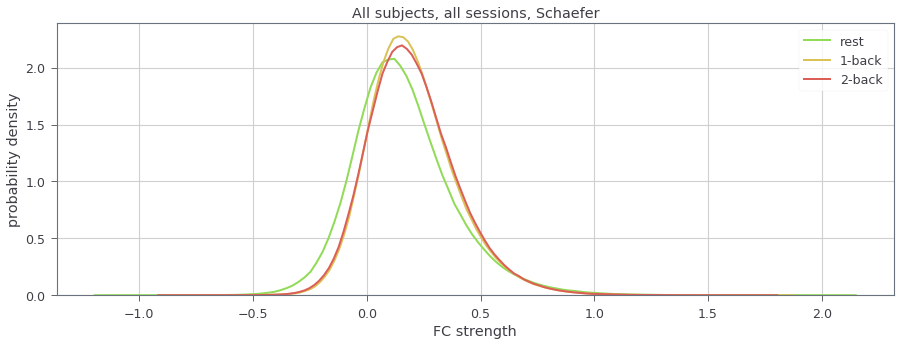

In [24]:
fig = plt.figure(figsize=(15, 5), facecolor='white')

for i, task in enumerate(['rest', '1-back', '2-back']):
    
    draw_kde_hist(
        data=mat_sch_v[sub_both.index.values, 0, i].flatten(),
        color=color[task],
        label=task)
    plt.title('All subjects, all sessions, Schaefer')
    plt.xlabel('FC strength')
    plt.ylabel('probability density')

#### Schaefer atlas individual degree distributions (session 1)

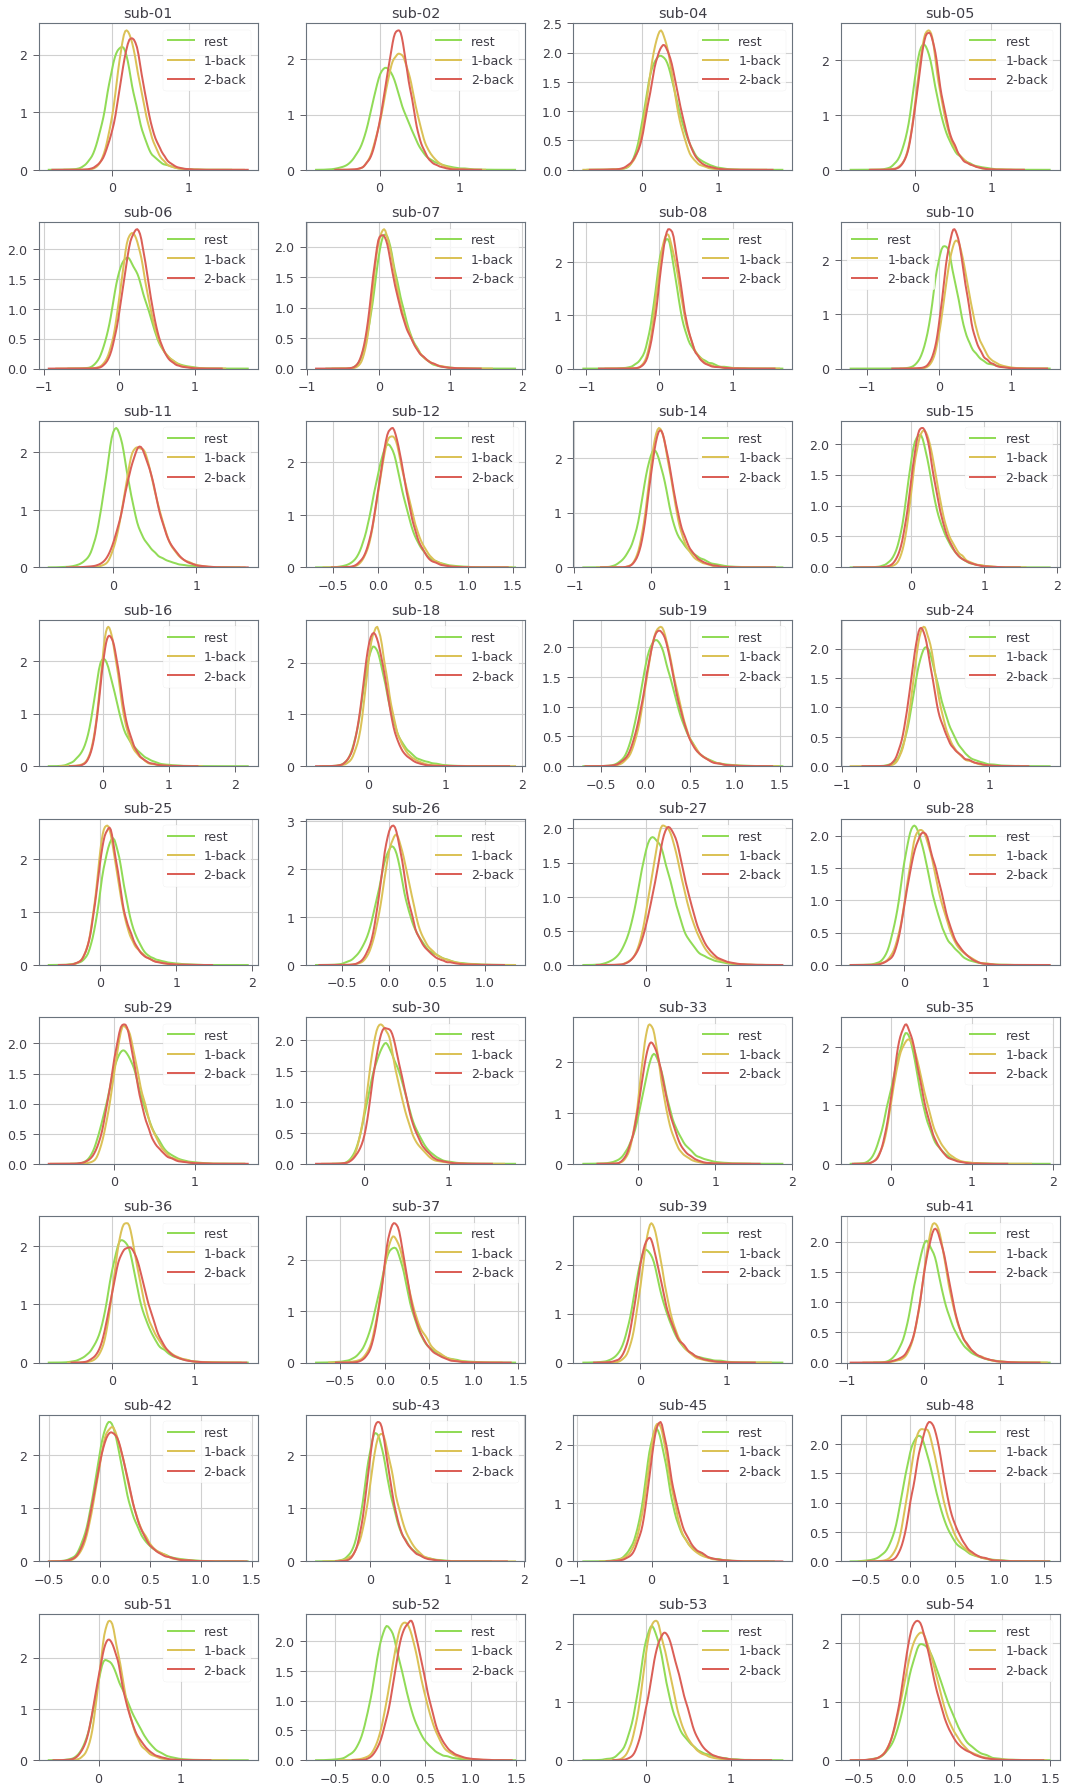

In [9]:
fig = plt.figure(figsize=(15, 25), facecolor='white')

for idx, sub_idx in enumerate(sub_both.index.values[:36]):
    
    fig.add_subplot(9, 4, idx+1)
    
    for i, task in enumerate(['rest', '1-back', '2-back']):
        
        draw_kde_hist(
            data=mat_sch_v[(sub_idx, 0, i)].flatten(),
            color=color[task],
            label=task)
        plt.title(sub_both['sub'][sub_idx])
        plt.tight_layout()

#### Power atlas mean degree distributions (all sessions)

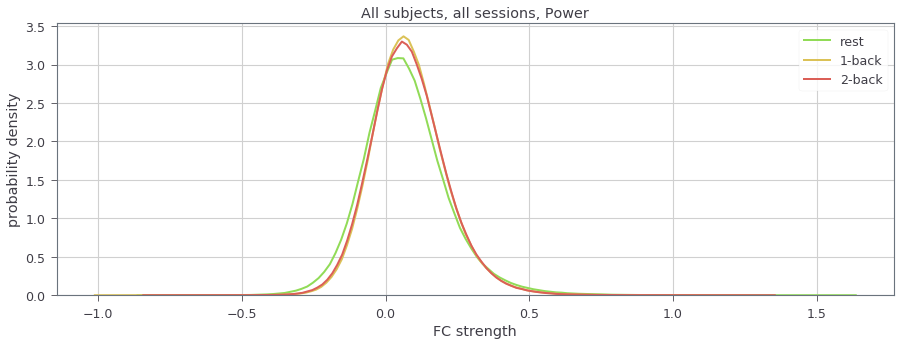

In [25]:
fig = plt.figure(figsize=(15, 5), facecolor='white')

for i, task in enumerate(['rest', '1-back', '2-back']):
    
    draw_kde_hist(
        data=mat_pow_v[sub_both.index.values, 0, i].flatten(),
        color=color[task],
        label=task)
    plt.title('All subjects, all sessions, Power')
    plt.xlabel('FC strength')
    plt.ylabel('probability density')

#### Power atlas individual degree distributions (session 1)

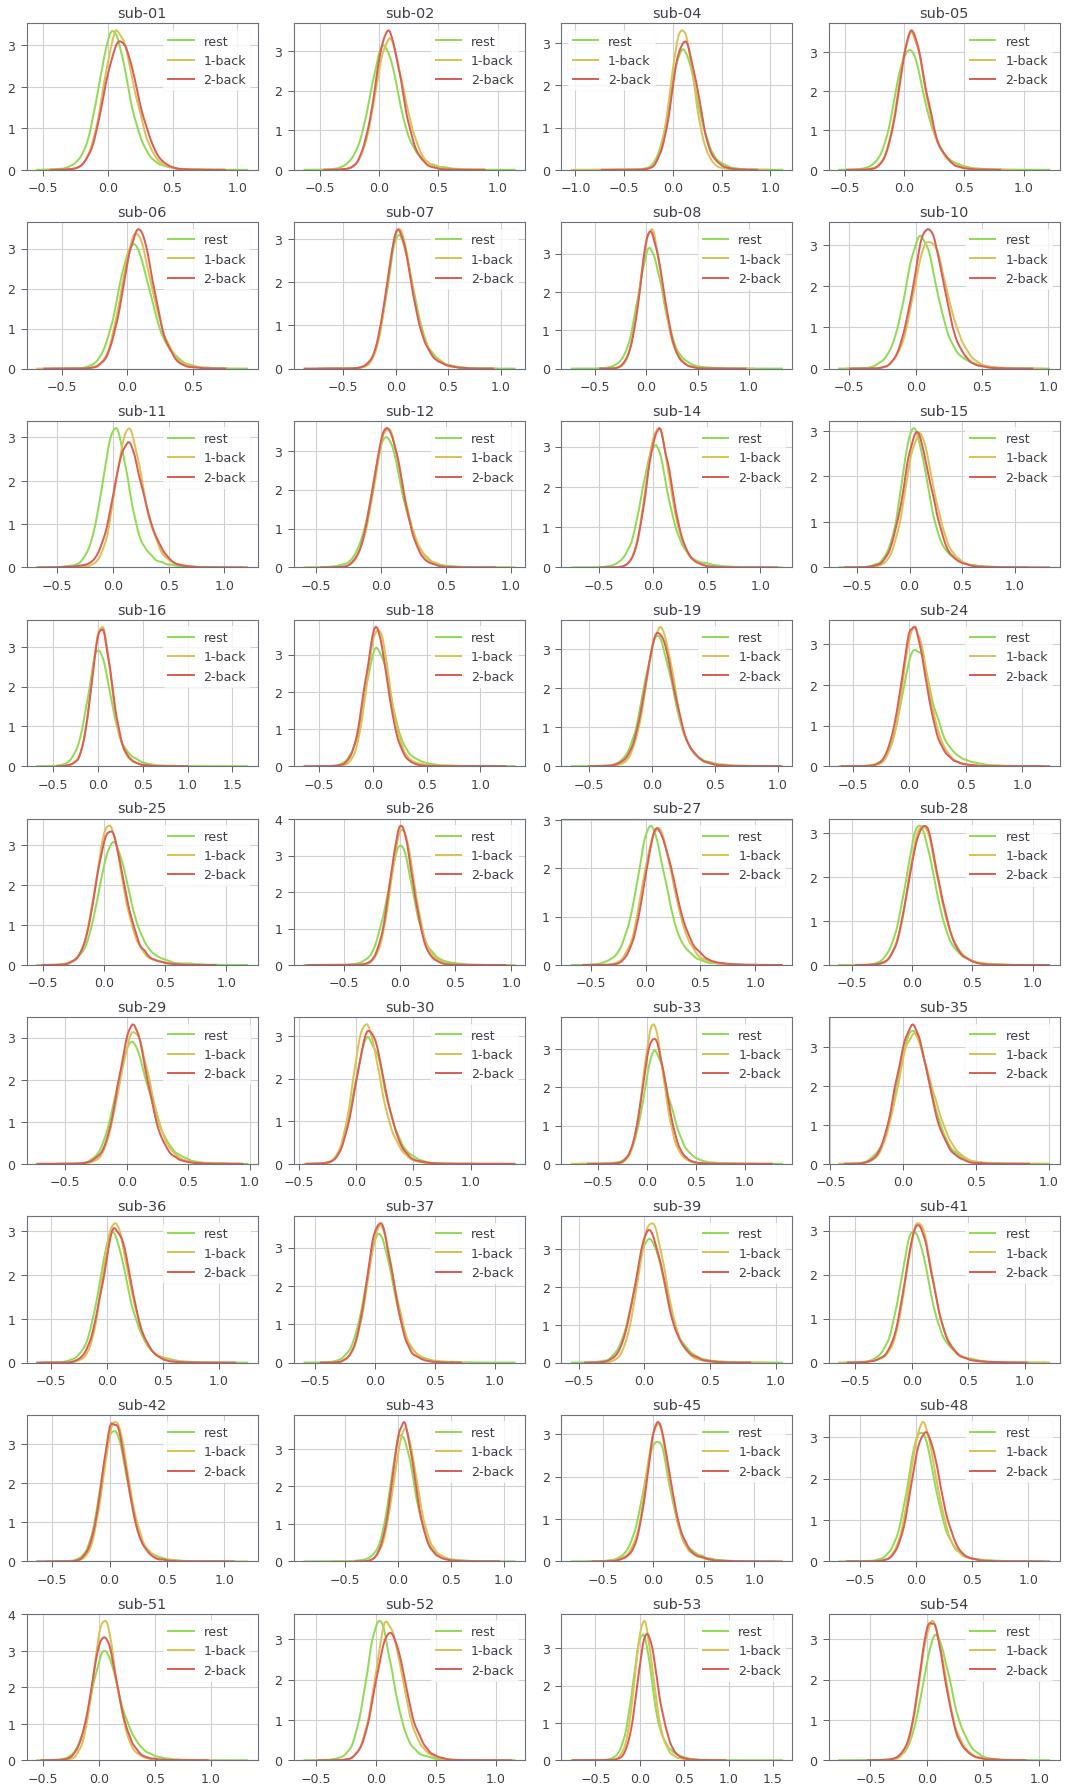

In [11]:
fig = plt.figure(figsize=(15, 25), facecolor='white')

for idx, sub_idx in enumerate(sub_both.index.values[:36]):
    
    fig.add_subplot(9, 4, idx+1)
    
    for i, task in enumerate(['rest', '1-back', '2-back']):
        
        draw_kde_hist(
            data=mat_pow_v[(sub_idx, 0, i)].flatten(),
            color=color[task],
            label=task)
        plt.title(sub_both['sub'][sub_idx])
        plt.tight_layout()

### Section 1.2. Degree distribution differences between groups and sessions
Perform basic statistical analysis of degree distribution (compare mean and std between groups and sessions).

In [181]:
def create_dataframe(metric, sub_df, var_name):
    '''Creating tidy-style dataframe from 2-D numpy array
    
    Parameters:
        metric (ndarray): Two dimensional array of shape (N_sub, 4).
        sub_df (DataFrame): Subject group assignment.
        var_name (str): Specifies name of metric.
        
    Note:
        Index of sub_df should match corresponding rows of metric. 
        
    Returns:
        df (DataFrame): Tidy format with group, session and value indices.'''

    df = pd.DataFrame(
        metric, 
        columns=(['ses-1', 'ses-2', 'ses-3', 'ses-4']))

    df = pd.merge(df, sub_df, left_index=True, right_index=True)
    df = df.drop(['sub'], axis=1)
    df = df.set_index('group')
    df = df.stack()
    df.index = df.index.rename('session', level=1)
    df.name = var_name
    df = df.reset_index()
    return df

In [156]:
# Calculate mean network degree 
k_pow = mat_pow_v.mean(axis=3)
k_std_pow = mat_pow_v.std(axis=3)
k_sch = mat_sch_v.mean(axis=3)
k_std_sch = mat_sch_v.std(axis=3)

#### Schaefer atlas mean connectivity and std of connectivity 

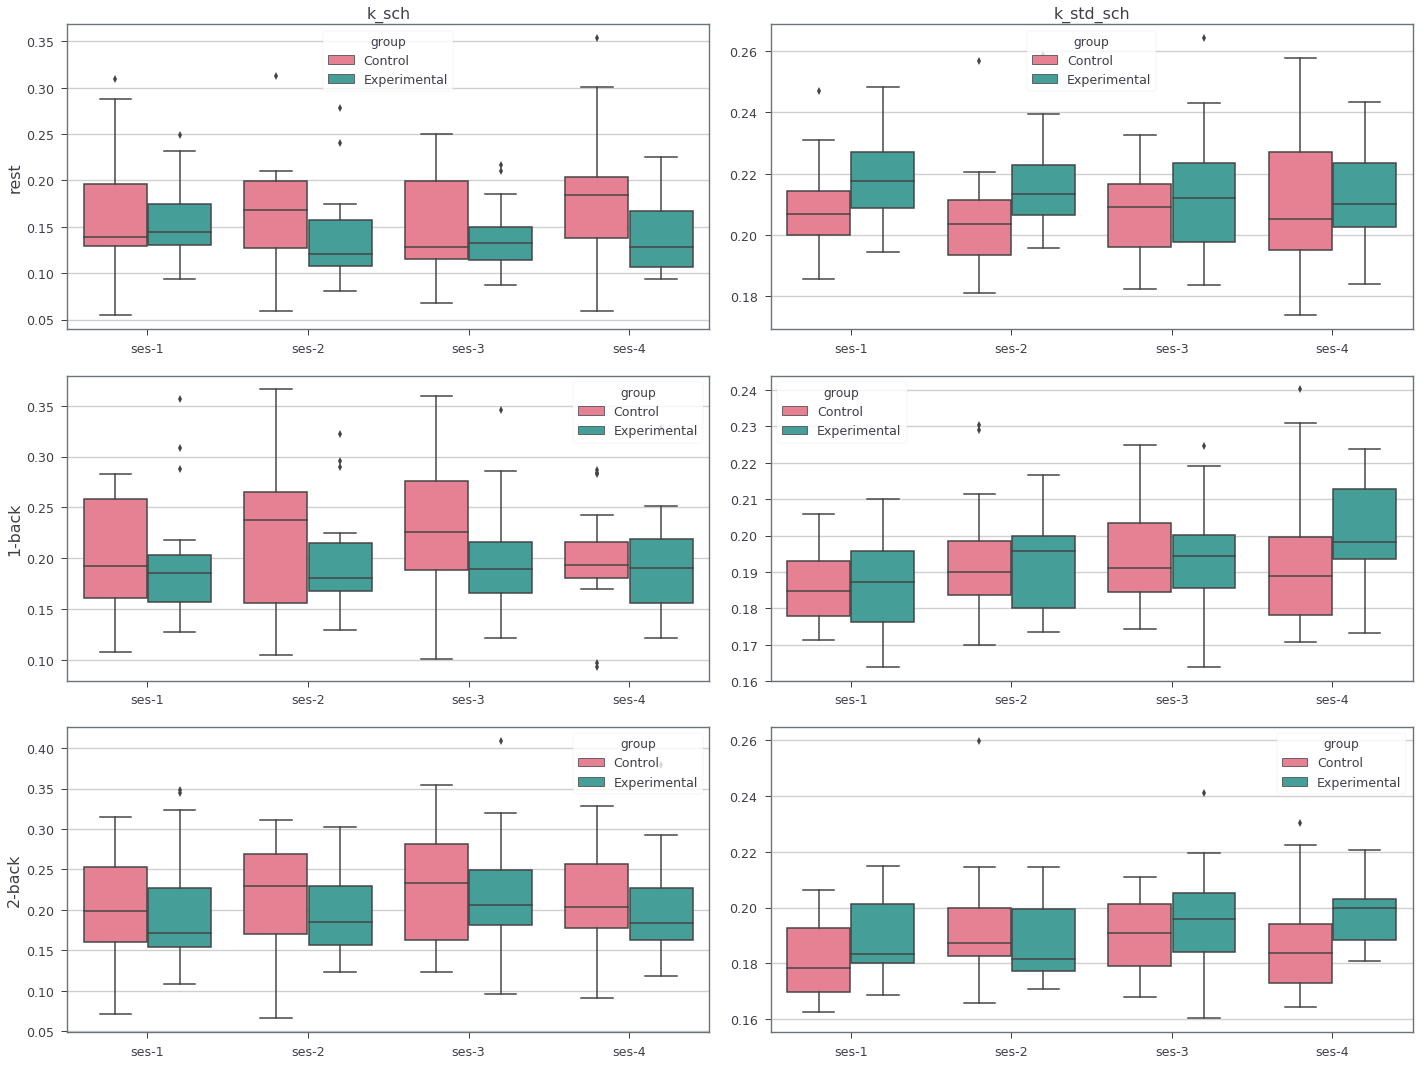

In [205]:
metrics = ['k_sch', 'k_std_sch']
tasks = ['rest', '1-back', '2-back']

fig, ax = plt.subplots(3, 2, 
                       figsize=(20, 15),
                       facecolor='w',
                       edgecolor='k')

for iy, task in enumerate(tasks):
    for ix, var_name in enumerate(metrics):
            
        if var_name == metrics[0]:
            df = create_dataframe(k_sch[:,:,iy], sub_both, var_name)
        else:
            df = create_dataframe(k_std_sch[:,:,iy], sub_both, var_name)

        sns.boxplot(
            ax=ax[iy, ix],
            x='session',
            y=var_name,
            hue='group',
            data=df,
            palette='husl')
        
        ax[iy, ix].set_axisbelow(True)
        if ix == 0:
            ax[iy, ix].set_ylabel(task, size='large')
        else:
            ax[iy, ix].set_ylabel('')
        if iy == 0:
            ax[iy, ix].set_title(var_name, size='large')
        ax[iy, ix].set_xlabel('')
            
plt.tight_layout()



#### Power atlas mean connectivity and std of connectivity 

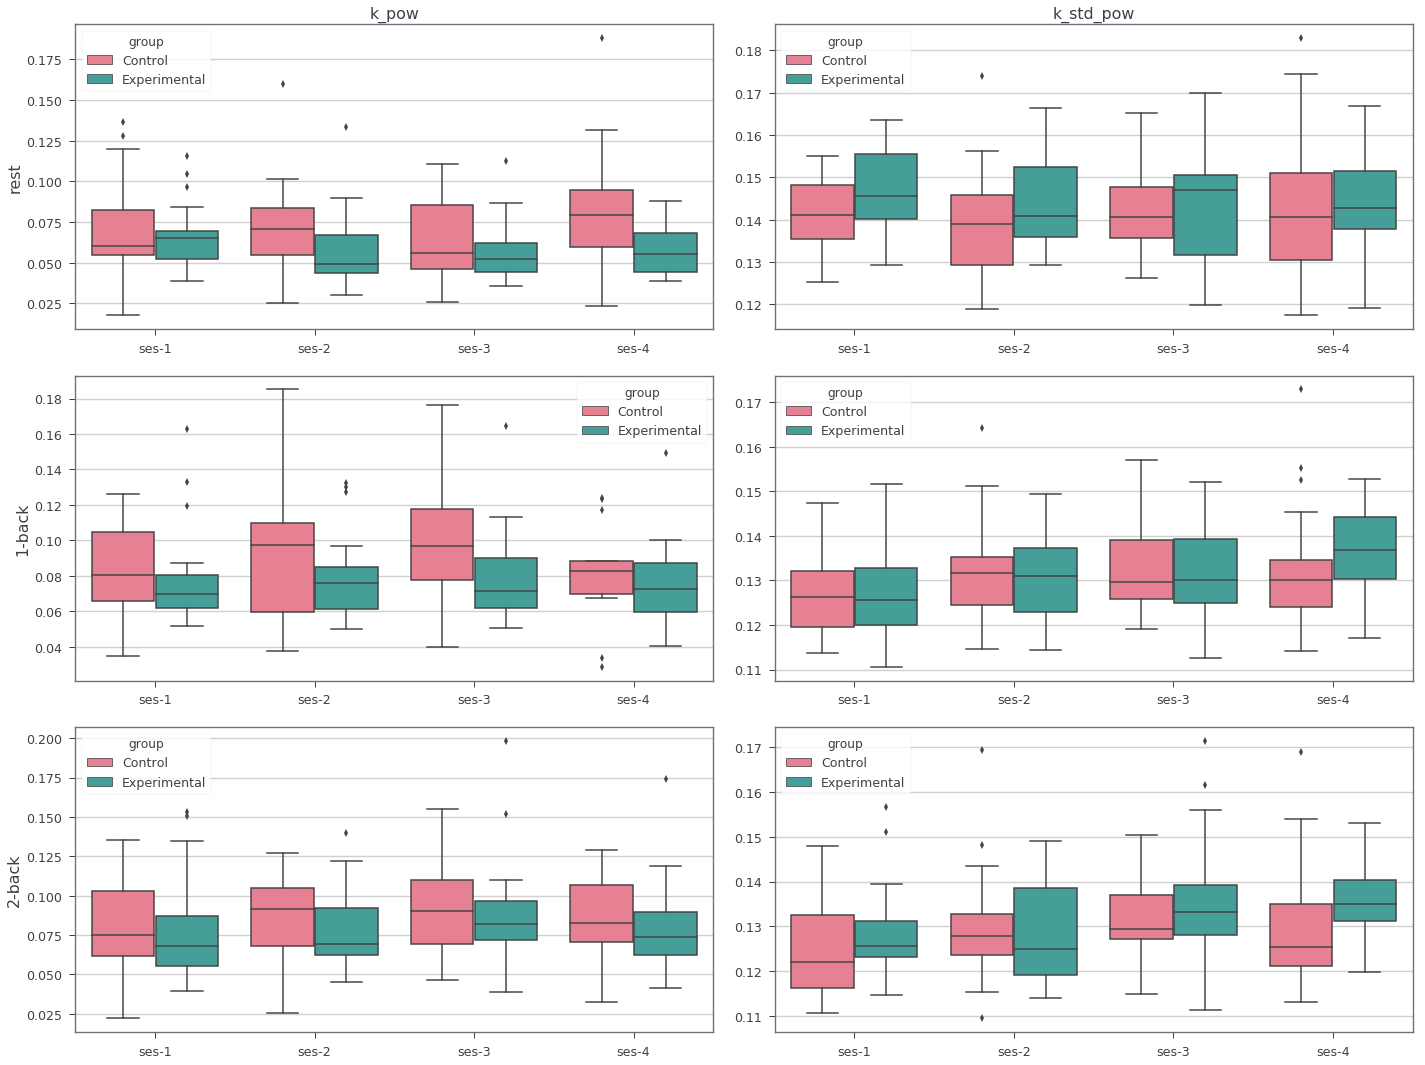

In [207]:
metrics = ['k_pow', 'k_std_pow']
tasks = ['rest', '1-back', '2-back']

fig, ax = plt.subplots(3, 2, 
                       figsize=(20, 15),
                       facecolor='w',
                       edgecolor='k')

for iy, task in enumerate(tasks):
    for ix, var_name in enumerate(metrics):
            
        if var_name == metrics[0]:
            df = create_dataframe(k_pow[:,:,iy], sub_both, var_name)
        else:
            df = create_dataframe(k_std_pow[:,:,iy], sub_both, var_name)

        sns.boxplot(
            ax=ax[iy, ix],
            x='session',
            y=var_name,
            hue='group',
            data=df,
            palette='husl')
        
        ax[iy, ix].set_axisbelow(True)
        if ix == 0:
            ax[iy, ix].set_ylabel(task, size='large')
        else:
            ax[iy, ix].set_ylabel('')
        if iy == 0:
            ax[iy, ix].set_title(var_name, size='large')
        ax[iy, ix].set_xlabel('')
            
plt.tight_layout()

In [73]:
subs = sub_both.index.values
task = 2

corr = np.empty((len(subs), 4, 4))

for sub_id, sub in enumerate(subs):
    for prod in itertools.product(list(range(4)), repeat=2):
        corr[(sub_id, *prod)] = np.corrcoef(
            x=mat_pow_v[sub, prod[0], task],         
            y=mat_pow_v[sub, prod[1], task]
        )[0][1]
        
print(np.mean(corr, axis=0))

[[1.         0.35956338 0.37090722 0.37237356]
 [0.35956338 1.         0.39356035 0.39053156]
 [0.37090722 0.39356035 1.         0.41578736]
 [0.37237356 0.39053156 0.41578736 1.        ]]


In [47]:
np.max(corr, axis=0)

array([[1.        , 0.6167258 , 0.58152322, 0.59362333],
       [0.6167258 , 1.        , 0.64755311, 0.60731948],
       [0.58152322, 0.64755311, 1.        , 0.61982289],
       [0.59362333, 0.60731948, 0.61982289, 1.        ]])